In [181]:
import numpy as np
import pandas as pd
import datetime
from sklearn.metrics import mean_squared_error 
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import seaborn as sns
import gc
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, Activation
from lstmPrice_Prediction import PricePrediction
import warnings
warnings.filterwarnings("ignore")

### Load in Data and Clean:

In [4]:
# Load historical data from file:
df = pd.read_csv('eth_historical_data.csv')

# Convert timezones and reformat:
df['time_period_start'] = pd.to_datetime(df['time_period_start']).dt.tz_convert('US/Central').dt.strftime('%m-%d-%Y %H:%M')
# Reset Index
df.set_index('time_period_start', inplace=True)
# Pull just the value fields:
df = df[['price_open', 'price_high', 'price_low', 'price_close', 'volume_traded', 'trades_count']]
df.head()

,price_open,price_high,price_low,price_close,volume_traded,trades_count
time_period_start,,,,,,
06-24-2019 17:00,308.84,313.09,308.84,311.24,3454.712211,460
06-24-2019 17:30,311.23,311.70,308.12,308.80,511.260554,100
06-24-2019 18:00,308.89,310.31,308.24,308.91,1355.438085,145
06-24-2019 18:30,308.81,310.44,308.81,310.44,129.936307,134
06-24-2019 19:00,310.75,312.40,309.79,310.43,2269.709662,410


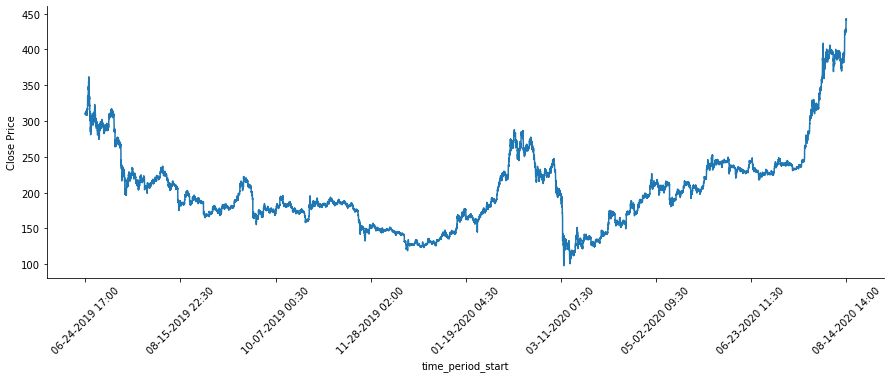

In [5]:
# Plot the closing prices just as a reference:
df['price_close'].plot(figsize=(15,5))
plt.ylabel('Close Price')
plt.xticks(rotation=45)
sns.despine()
plt.show()

### Prepare Data for Modeling

In [126]:
lstm = PricePrediction()
lstm.load_dataframe(df)
train_set, test_set = lstm.split_data()

n_input = 3 
n_out = 1

X_train, y_train = lstm.to_supervised(train_set, n_input, n_out)
X_test, y_test = lstm.to_supervised(test_set, n_input, n_out)

X_train_norm, y_train_norm = lstm.normalize_inputs(X_train, y_train)
X_test_norm, y_test_norm = lstm.normalize_inputs(X_test, y_test)

In [131]:
neurons = 1024               # number of hidden units in the LSTM layer
activation_function = 'tanh'  # activation function for LSTM and Dense layer
loss = 'mse'                  # loss function for calculating the gradient, in this case Mean Squared Error
optimizer= 'adam'             # optimizer for appljying gradient decent
dropout = 0.25                # dropout ratio used after each LSTM layer to avoid overfitting
batch_size = 128              
epochs = 12

def build_model(inputs, output_size, neurons, activ_func=activation_function, dropout=dropout, loss=loss, optimizer=optimizer):
    model = Sequential()
    model.add(LSTM(neurons, return_sequences=True, input_shape=(inputs.shape[1], inputs.shape[2]), activation=activ_func))
    model.add(Dropout(dropout))
    model.add(LSTM(neurons, return_sequences=True, activation=activ_func))
    model.add(Dropout(dropout))
    model.add(LSTM(neurons, return_sequences=True, activation=activ_func))
    model.add(Dropout(dropout))
    model.add(LSTM(neurons, activation=activ_func))
    model.add(Dropout(dropout))
    model.add(Dense(units=n_out))
    model.add(Activation(activ_func))
    model.compile(loss=loss, optimizer=optimizer, metrics=['mae']) 
    model.summary()
    return model

In [134]:
# clean up the memory
gc.collect()

# random seed for reproducibility
np.random.seed(202)

# initialise model architecture
model = build_model(X_train_norm, n_out, neurons=neurons)
results = model.fit(X_train_norm, y_train_norm, epochs=epochs, batch_size=batch_size, verbose=1, validation_data=(X_test_norm, y_test_norm), shuffle=False)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 3, 1024)           4222976   
_________________________________________________________________
dropout (Dropout)            (None, 3, 1024)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 3, 1024)           8392704   
_________________________________________________________________
dropout_1 (Dropout)          (None, 3, 1024)           0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 3, 1024)           8392704   
_________________________________________________________________
dropout_2 (Dropout)          (None, 3, 1024)           0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 1024)              8

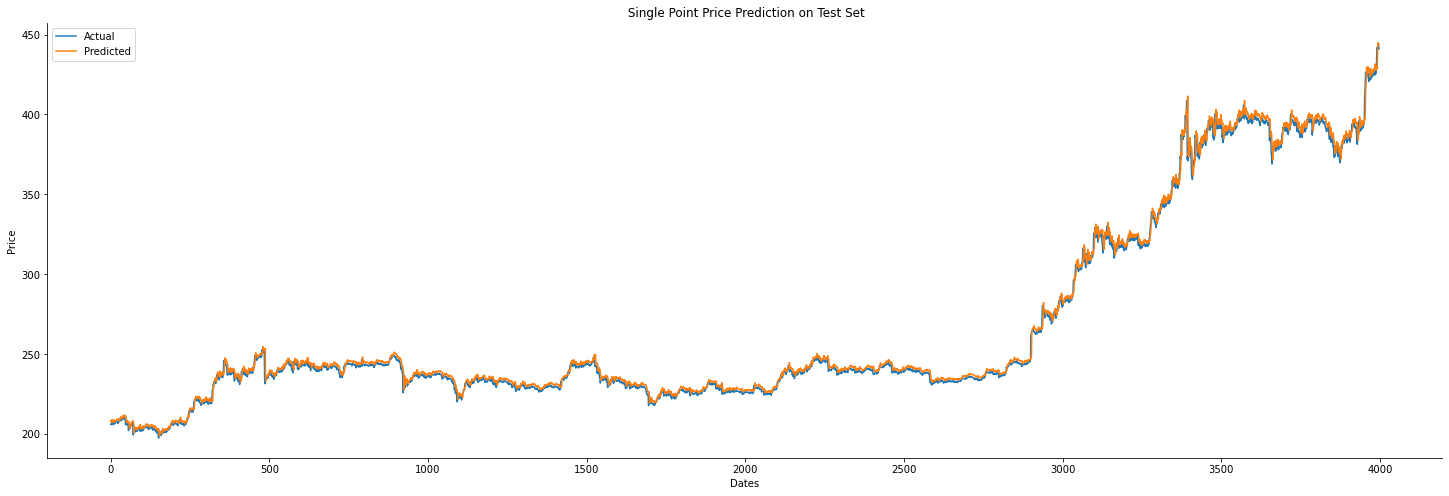

In [162]:
plt.figure(figsize=(25,8))
plt.plot(y_test)
plt.plot(((model.predict(X_test_norm)+1) * test_set['price_close'][:-n_input].values)[0])
plt.xlabel('Dates')
plt.ylabel('Price')
plt.title(' Single Point Price Prediction on Test Set')
plt.legend(['Actual','Predicted'])
sns.despine()
plt.show()

### Prediction Analysis

In [184]:
test_set['predicted_price_close'] = [None, None, None] + ((model.predict(X_test_norm)+1) * test_set['price_close'][:-n_input].values)[0].tolist()

In [187]:
test_set['close_pct_change'] = test_set['price_close'].pct_change()
test_set['predicted_pct_change'] = test_set['predicted_price_close'].pct_change()

In [191]:
def predict_label(df):
    if (df['close_pct_change'] > 0) & (df['predicted_pct_change'] > 0):
        return 'true_positive'
    if (df['close_pct_change'] < 0) & (df['predicted_pct_change'] < 0):
        return 'true_negative'
    if (df['close_pct_change'] > 0) & (df['predicted_pct_change'] < 0):
        return 'false_negative'
    if (df['close_pct_change'] < 0) & (df['predicted_pct_change'] > 0):
        return 'false_positive'
    
test_set['predict_label'] = test_set.apply(predict_label, axis=1)

In [195]:
test_set.head(15)

,price_open,price_high,price_low,price_close,volume_traded,trades_count,predicted_price_close,close_pct_change,predicted_pct_change,predict_label
time_period_start,,,,,,,,,,
05-23-2020 05:30,206.11,206.57,205.51,206.50,403.466819,86,NaN,NaN,NaN,None
05-23-2020 06:00,206.50,207.38,206.27,206.77,658.528596,157,NaN,0.001308,NaN,None
05-23-2020 06:30,206.65,207.83,206.65,207.54,888.478460,166,NaN,0.003724,NaN,None
05-23-2020 07:00,207.53,207.53,206.06,206.09,643.800380,171,207.900174,-0.006987,NaN,None
05-23-2020 07:30,206.06,206.40,204.68,206.40,989.693407,224,208.172005,0.001504,0.001308,true_positive
05-23-2020 08:00,206.38,206.92,206.14,206.51,545.003288,87,208.947226,0.000533,0.003724,true_positive
05-23-2020 08:30,206.51,206.78,206.16,206.19,158.907657,37,207.487394,-0.001550,-0.006987,true_negative
05-23-2020 09:00,206.14,207.54,205.59,207.48,644.147195,123,207.799496,0.006256,0.001504,true_positive
05-23-2020 09:30,207.55,208.19,207.55,207.78,820.276607,155,207.910242,0.001446,0.000533,true_positive


In [194]:
test_set['predict_label'].value_counts(normalize=True)

false_negative    0.257925
false_positive    0.257418
true_positive     0.251585
true_negative     0.233071
Name: predict_label, dtype: float64